# Capsule Network

In this notebook, I'll be building a simple Capsule Network that aims to classify MNIST images. This is an implementation in PyTorch and this notebook assumes that you are already familiar with [convolutional and fully-connected layers](https://cezannec.github.io/Convolutional_Neural_Networks/). 

### What are Capsules?

Capsules are a small group of neurons that have a few key traits:
>* Each neuron in a capsule represents various properties of a particular image part; properties like a parts color, width, etc. 
* Every capsule **outputs a vector**, which has some magnitude (that represents the probability of a part's **existence**) and orientation (that represents a part's generalized pose).
* A capsule network is made of multiple layers of capsules; during training, this network aims to learn the spatial relationships between the parts and whole of an object (ex. how the position of eyes and a nose relate to the position of a whole face in an image).
* Capsules represent relationships between parts of a whole object by using **dynamic routing** to weight the connections between one layer of capsules and the next and creating strong connections between spatially-related object parts. 

<img src='assets/cat_face_2.png' width=50% />

You can read more about all of these traits in [my blog post about capsules and dynamic routing](https://cezannec.github.io/Capsule_Networks/).

### Representing Relationships Between Parts

All of these traits allow capsules to communicate with each other and determine how data moves through them. Using dynamic communication, during the training process, a capsule network learns the **spatial relationships** between visual parts and their wholes (ex. between eyes, a nose, and a mouth on a face). When compared to a vanilla CNN, this knowledge about spatial relationships makes it easier for a capsule network to identify an object no matter what orientation it is in. These networks are also better able to identify multiple, overlapping objects, and learn from smaller sets of training data! 

---
## Model Architecture

The Capsule Network that I'll define is made of two main parts:
1. A convolutional encoder
2. A fully-connected, linear decoder

I'll be following the architecture described [in the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf). I'll describe each layer in more detail as I define it in this notebook, but first let's load in our resources and MNIST data. I'm also setting a random seed, for reproducibility.

In [1]:
# import resources
import numpy as np
import torch

# random seed (for reproducibility)
seed = 1
# set random seed for numpy
np.random.seed(seed)
# set random seed for pytorch
torch.manual_seed(seed)

### Obtain the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` parameter, if you want to load more data at a time, but the included parameters are fine to leave as is.

This cell will create `DataLoaders` for the training and test sets.

Egyptian Hieroglyph

In [2]:
# Connecting and Mounting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import os

data_dir = '/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

In [5]:
hieroglyph_for_train = []
file_count_list = []

for name in os.listdir('/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/train/'):
  path, dirs, files = next(os.walk("/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/train/"+name))
  file_count = len(files)
  print(name, file_count)
  file_count_list.append(file_count)
  hieroglyph_for_train.append(name)

hieroglyph_dict = dict(zip(hieroglyph_for_train, file_count_list))

Y5 6
I9 116
O34 15
V13 63
U7 3
D46 40
E34 97
G1 28
V31 106
S34 8
D36 47
Q1 13
V30 6
F35 2
O4 11
M23 30
S29 212
R8 53
W11 4
X1 185
Y1 1
D21 146
D2 19
E23 8
X8 4
Z1 39
D4 29
V28 28
I10 32
O1 16
M17 291
F31 6
G43 157
D58 28
O49 10
G17 156
R4 2
Q3 61
W24 31
N35 358


<BarContainer object of 40 artists>

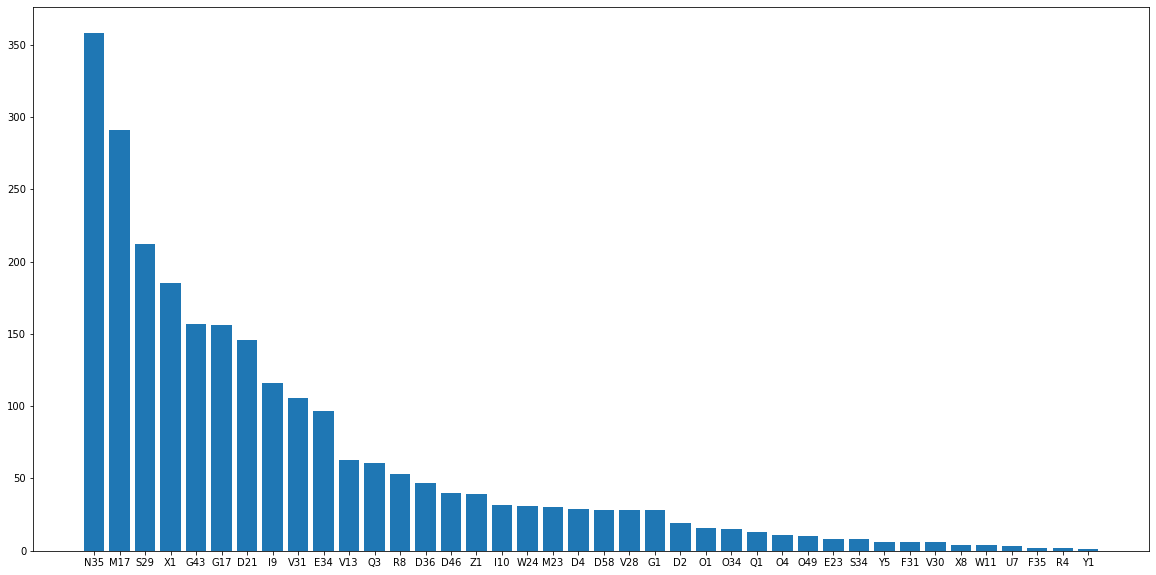

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({"Hieroglyph":hieroglyph_for_train, "Count":file_count_list})

df_sorted= df.sort_values('Count',ascending=False)

plt.figure(figsize=(20,10))
# make bar plot with matplotlib
plt.bar('Hieroglyph', 'Count',data=df_sorted)

In [7]:
# classes are folders in each directory with these names
classes = []

for filename in os.listdir(train_dir):
    classes.append(filename)

classes.sort()

print(classes)
print(len(classes))

['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17', 'G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3', 'R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1', 'X8', 'Y1', 'Y5', 'Z1']
40


In [8]:
from torchvision import datasets
import torchvision.transforms as transforms

data_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Grayscale(num_output_channels=1),
                                        transforms.Resize((75, 75)),
                                        transforms.Normalize((0.5,), (0.5,))
                                        ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  2467
Num test images:  634


In [9]:
def get_class_distribution(dataset_obj, idx2class):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [10]:
# define dataloader parameters
batch_size = 20
num_workers = 0

# WeightedRandomSampler for train loader
idx2class = {v: k for k, v in train_data.class_to_idx.items()}

target_list = torch.tensor(train_data.targets)
class_count = [i for i in get_class_distribution(train_data, idx2class).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights_all = class_weights[target_list]
weighted_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights_all, num_samples=len(class_weights_all), replacement=True)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            num_workers=num_workers, sampler=weighted_sampler, drop_last=True)

# WeightedRandomSampler for test loader
idx2class_test = {v: k for k, v in test_data.class_to_idx.items()}

target_list_test = torch.tensor(test_data.targets)
class_count_test = [i for i in get_class_distribution(test_data, idx2class_test).values()]
class_weights_test = 1./torch.tensor(class_count_test, dtype=torch.float) 
class_weights_all_test = class_weights_test[target_list_test]
weighted_sampler_test = torch.utils.data.WeightedRandomSampler(weights=class_weights_all_test, num_samples=len(class_weights_all_test), replacement=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, sampler=weighted_sampler_test)

### Visualize Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data. 
> Each image is `28` pixels in width and height and `1` in depth. I'll sometimes write this as an image with dimensions `(28, 28, 1)`.

If you recall, the depth is just the number of color channels in an image, so 1 is the depth for a grayscale image and 3 is the depth for an RGB image.

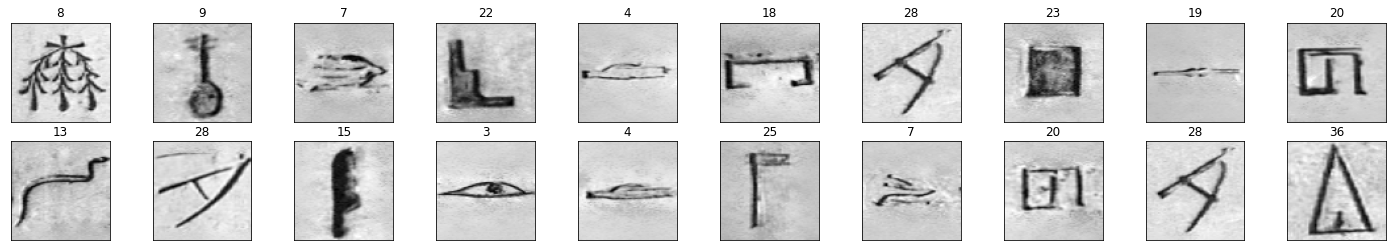

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

---
# Encoder

The encoder is made of a series of layers that are responsible for taking in as input a 28 by 28 MNIST image and learning to encode it into a 16-dimensional output vector.

<img src='assets/capsule_encoder.png' width=70%/>

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

## First Layer: Convolutional Layer

The first layer in our encoder is a convolutional layer that will learn to extract features, like edges, in a given input image. 
> In the original paper, this first convolutional layer has a `depth=256`, and uses a `kernel_size=9`, `stride=1`, and `padding=0`. This also calls for a `ReLu` activation on the outputs.

So, this convolutional layer will create a stack of 256 filtered images, given one input MNIST image. 

For a 28x28 input image, a 9x9 kernel will not be able to perfectly overlay on the edges pixels of an image and, without any padding, I'll actually lose a border of 4 pixels on *each* side of the image as I filter it. So, for an input of size `(batch_size, 28, 28, 1)`, I'll get an output, convolutional layer with the dimensions `(batch_size, 20, 20, 256)`. And `batch_size` is just the number of input images that are processed in a batch; defined above in the `DataLoader` as `20`.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=256): # 75 x 75 x 1
        '''Constructs the ConvLayer with a specified input and output size.
           param in_channels: input depth of an image, default value = 1
           param out_channels: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=9, stride=2, padding=0)

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input to the layer; an input image
           return: a relu-activated, convolutional layer
           '''
        # applying a ReLu activation to the outputs of the conv layer
        features = F.relu(self.conv(x)) # will have dimensions (batch_size, 34, 34, 256)
        return features
    

## Second Layer: Primary Capsules

This layer is composed of 8 "primary" capsules, so called because they are the first layer of capsules. They take the output of the previously defined, convolutional layer as input and produce a set of output vectors. Essentially, each capsule is responsible for producing weighted combinations of the features detected in the previous convolutional layer. 

As per the paper, to get the output of one capsule, I'll:
>* Define a convolutional layer with a `depth=32`, `kernel_size=9`, `**stride=2**`, and `padding=0` and apply it to the features from the previous layer.
* By applying a convolutional layer to features of size `(batch_size, 20, 20, 256)`, I will get a `(batch_size, 6, 6, 32)` Tensor as output for each of the 8 capsules. 
* I'll **reshape** this into an output vector using `.view(batch_size, 32*6*6, 1)`, for each of our 8 capsules and then stack those vectors.
* Finally, I'll **squash** all of these vector; this is a nonlinear normalization step that forces the magnitude of the vectors to be in the range 0-1. 

#### A note on calculating dimensions

You may be wondering how I got from 20x20 to 6x6.

Again, I'm creating a border of 4 pixels on each side with a kernel_size of 9. So, I'll go from an x-y size of 20 - 4 on *all* sides to a size of 12. Then, with a `stride=2`, I'm efectively downsampling the previous inputs by a factor of 2, so I go from an x-y size of 12, divided by 2, to get an x-y size of 6. And you can read more about these precise output dimension calculations [at this Stanford cs231n page](http://cs231n.github.io/convolutional-networks/#conv) in the section on **spatial arrangement**.

### Squashing

> The magnitude of an output, capsule vector is a value between 0 and 1 that indicates the probability that a visual part (eyes, nose, etc.) exists and has been detected in an image. 

To get this probability value, I define a nonlinear function `squash` that calculates a certain capsule's normalized, vector output using the following equation. 

$$ v_j = \frac{||\ s_j^2\ ||\ s_j }{1 + ||\ s_j^2\ ||\ s_j } $$

$v_j$ is the value I want to calculate, the normalized vector output of a capsule $j$. And $s_j$ is that capsule's total input; a weighted sum over all the output vectors from the capsules in the layer *below* capsule $j$. For all but the primary capsule layer, you can think of the weighted inputs as the number of smaller *parts* that think they are part of a larger whole. The idea is that if you detect a nose and eyes in one layer, with some probability (the magnitude of a vector), this is evidence that a larger face exists in the next layer.

> The `squash` function is a nonlinear function of the weighted inputs to a single capsule. It ensures that the magnitude of $v_j$ is a value between 0 and 1.

#### ModuleList

Below, I'm taking advantage of PyTorch's [nn.ModuleList](https://pytorch.org/docs/stable/nn.html#modulelist) container to create a list of convolutional layers that is as long as my number of passed in capsules, `num_capsules`.

In [14]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32):
        '''Constructs a list of convolutional layers to be used in 
           creating capsule output vectors.
           param num_capsules: number of capsules to create
           param in_channels: input depth of features, default value = 256
           param out_channels: output depth of the convolutional layers, default value = 32
           '''
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters (batch_size, 34, 34, 256)
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=8, stride=2, padding=0)
            for _ in range(num_capsules)])
    
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; features from a convolutional layer
           return: a set of normalized, capsule output vectors
           '''
        # get batch size of inputs
        batch_size = x.size(0)
        # reshape convolutional layer outputs to be (batch_size, vector_dim=32*14*14, 1)
        u = [capsule(x).view(batch_size, 32 * 14 * 14, 1) for capsule in self.capsules]
        # stack up output vectors, u, one for each capsule
        u = torch.cat(u, dim=-1)
        # squashing the stack of vectors
        u_squash = self.squash(u)
        return u_squash
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor
    

## Third Layer: Digit Capsules

This layer is composed of 10 "digit" capsules, one for each of our digit classes 0-9. Each capsule takes, as input, a batch of 1152-dimensional vectors produced by our 8 primary capsules, above. 

> This is the final layer of the encoder portion of the network, and each of these 10 capsules is responsible for producing a 16-dimensional output vector.

In other words, this layer is mapping from 1152-dimensional, input vector space to 16-dimensional, output vector space. This is also where you'll see **dynamic routing** implemented.

## Dynamic Routing

Dynamic routing is a process for finding the *best* connections between the output of one layer of capsules and the inputs of the next layer of capsules. It allows capsules to communicate with each other and determine how data moves through them! 
> No matter what kind of input image a capsule network sees, dynamic routing ensures that the output of a *child* capsule in the `PrimaryCaps` layer will be sent to the most-relevant *parent* capsule in this `DigitCaps` layer.

### Coupling Coefficients

When a capsule network is initialized, the primary capsules are not sure which parents (digit capsules) their outputs should go to. In fact, each primary capsule starts out with a list of **possible parents** that starts out as *all* of the parent capsules in the next layer. 

> This possible relationship is represented by a value called the **coupling coefficient**, **c**, which is the probability that a certain capsule’s output should go to a parent capsule in the next layer. 

Examples of coupling coefficients, written on the connecting lines between a child and its possible parent nodes, are pictured below. A child node with two possible parents will start out with equal coupling coefficients for both: 0.5.

<img src='assets/coupling_coeff.png' width=30%/>

(Image from [my blog post on Capsule Nets](https://cezannec.github.io/Capsule_Networks/))

The coupling coefficients across all possible parents can be pictured as a discrete probability distribution. Across all connections between one child capsule and all possible parent capsules, the coupling coefficients should sum to 1.


### Routing by Agreement

Dynamic routing is an iterative process that updates these coupling coefficients. The coupling coefficients $c_{ij}$ between capsule $i$ and all the capsules $j$ in the layer above it sum to 1 and are determined by a routing **softmax** function whose initial logits $b_{ij}$ are the log prior probabilities that capsule $i$ *should* be coupled to capsule $j$. There are as many $b_{ij}$ as there are possible connections between the output vector of a primary capsule (length 1152) and digit capsules (10).


$$c_{ij} = \frac{e^{\ b_{ij}}}{\sum_{k}\ {e^{\ b_{ik}}}} $$

The update process, performed during network training, is as follows for a single capsule:

> 1. Every child capsule will output some vector $u$, whose magnitude indicates a part's *existence* and whose orientation represents the generalized pose of the part.
2. For each possible parent, a child capsule computes a prediction vector, $\hat{u}$, which is a function of its output vector, $u$, times a weight matrix, $W$. $W$ represents a linear transformation in space—like some rotation and translation—$\hat{u}$ can be thought of as a prediction about the position and orientation of a parent capsule's output vector.
3. If the prediction vector, $\hat{u}$, has a large **dot product** with the parent capsule output vector, $v$, then those vectors are said to **agree** and the coupling coefficient between *that* parent and the child capsule increases while the coupling coefficient between that child capsule and *all other* parents, decreases.
4. This dot product between the parent output vector, $v$, and a prediction vector, $\hat{u}$, is known as a formal measure of capsule **agreement**, $a$.
5. This agreement then affects how informaton is weighted as it moved through the network.
6. A new $b_{ij}$ is calculated as the *current* $b_{ij}$ plus $a$.
7. New coupling coefficients $c_{ij}$ are calculated using the above softmax formula and the new $b_{ij}$.

$$\hat{u} = W u $$

$$a = v \cdot u $$

$$b_{ij} = b_{ij} + a $$



This is sometimes referred to as **top-down feedback**; feedback from a later layer of parent capsule outputs.

**A typical training process may include *three* agreement iterations, in which $b_{ij}$ is updated (through steps 1-7), a total of three times to get to the final coupling coefficients that will be used to calculate final outputs, $v_j$.**

> A high coupling coefficient, between a child and parent capsule, increases the contribution of the child to that parent, thus *further* aligning their two output vectors and making their agreement dot product even larger! This is called **routing by agreement**.

I should note that this calculation changes how I calculate the total inputs to a digit capsule, $s_j$, when compared to the earlier, `PrimaryCaps` layer. In the `DigitCaps` case, $s_j$ is a sum of all the input vectors from the capsules in the layer *below*, $u$ times the weight matrix $W$, in other words $W u = \hat{u}$, *also* multiplied by the coupling coefficients. The first layer of capsules sees only convolutional features as input and these features do not provide enough information for routing and using couping coefficients.

$$ s_j = \sum{c_{ij} \ \hat{u}}$$

In [15]:
import torch
import torch.nn.functional as F

def softmax(input_tensor, dim=1):
    # transpose input
    transposed_input = input_tensor.transpose(dim, len(input_tensor.size()) - 1)
    # calculate softmax
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    # un-transpose result
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input_tensor.size()) - 1)

In [16]:
# dynamic routing
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    '''Performs dynamic routing between two capsule layers.
       param b_ij: initial log probabilities that capsule i should be coupled to capsule j
       param u_hat: input, weighted capsule vectors, W u
       param squash: given, normalizing squash function
       param routing_iterations: number of times to update coupling coefficients
       return: v_j, output capsule vectors
       '''    
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        c_ij = softmax(b_ij, dim=2)

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
            # new b_ij
            b_ij = b_ij + a_ij
    
    return v_j # return latest v_j
    

## Digit Capsules

Now that I've defined the dynamic routing process, I can complete the `DigitCaps` class.
* This layer is composed of 10 "digit" capsules, one for each of our digit classes 0-9. 
* Each capsule takes, as input, a batch of 1152-dimensional vectors produced by our 8 primary capsules, above. 
* Each of these 10 capsules is responsible for producing a **16-dimensional** output vector.

I suggest you train on GPU for a faster training time, and I'm checking for the availability of a GPU device, below.

In [17]:
# it will also be relevant, in this model, to see if I can train on gpu
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')
    

Training on GPU!


In [18]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=len(classes), previous_layer_nodes=32*14*14, 
                 in_channels=8, out_channels=16):
        '''Constructs an initial weight matrix, W, and sets class variables.
           param num_capsules: number of capsules to create
           param previous_layer_nodes: dimension of input capsule vector, default value = 6272
           param in_channels: number of capsules in previous layer, default value = 8
           param out_channels: dimensions of output capsule vector, default value = 16
           '''
        super(DigitCaps, self).__init__()

        # setting class variables
        self.num_capsules = num_capsules
        self.previous_layer_nodes = previous_layer_nodes # vector input (dim=6272)
        self.in_channels = in_channels # previous layer's number of capsules

        # starting out with a randomly initialized weight matrix, W
        # these will be the weights connecting the PrimaryCaps and DigitCaps layers
        self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes, 
                                          in_channels, out_channels))

    def forward(self, u):
        '''Defines the feedforward behavior.
           param u: the input; vectors from the previous PrimaryCaps layer
           return: a set of normalized, capsule output vectors
           '''
        
        # adding batch_size dims and stacking all u vectors
        u = u[None, :, :, None, :]
        # 4D weight matrix
        W = self.W[:, None, :, :, :]

        # calculating u_hat = W*u
        u_hat = torch.matmul(u, W)

        # getting the correct size of b_ij
        # setting them all to 0, initially
        b_ij = torch.zeros(*u_hat.size())
        
        # moving b_ij to GPU, if available
        if TRAIN_ON_GPU:
            b_ij = b_ij.cuda()

        # update coupling coefficients and calculate v_j
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

        return v_j # return final vector outputs
    
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        # same squash function as before
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor
    

This completes the encoder portion of the model! Next, the decoder.

---
# Decoder 

The decoder sees as input the 16-dimensional vectors that are produced by the `DigitCaps` layer. In the `forward` function, the decoder identifies the "correct" capsule output vector; this vector is the vector with the largest vector magnitude of all ten digit capsule outputs (recall that vector magnitude correspond to a part's **existence** in an image). Then, the decoder upsamples that one vector, decoding it into a reconstructed image of a handwritten digit. 

> The decoder is learning a mapping from a capsule output vector to a 784-dim vector that can be reshaped into a 28x28 reconstructed image. 

<img src='assets/capsule_decoder.png' width=60% />

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

I want this reconstructed image and the original, input image to be as close as possible! So, when I train this network, I'll look at the difference between the input image and this decoder reconstruction; any difference (measured as Euclidean distance) will be recorded as the loss.

#### Reconstruction Loss
I'll discuss the network loss in more detail later. For now, know that the authors use this decoder-based, reconstruction loss to encourage the digit capsules to learn to encode information about the content of the original input image.

## Linear Layers

The decoder is made of three fully-connected, linear layers. These are simply defined with an input_size and output_size. The first layer sees the 10, 16-dimensional output vectors from the digit capsule layer and produces `hidden_dim=512` number of outputs. The next hidden layer just increase this depth by two, and the third and final linear layer produces an output of 784 values that can be reshaped into a 28x28 image!

The hidden layers have ReLu activations applied and the final, output layer has a **sigmoid** activation function to ensure that the outputs are all values in a valid pixel range 0-1.

In [19]:
class Decoder(nn.Module):
    def __init__(self, input_vector_length=16, input_capsules=len(classes), hidden_dim=512):
        '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
        super(Decoder, self).__init__()
        
        # calculate input_dim
        input_dim = input_vector_length * input_capsules
        
        # define linear layers + activations
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 75*75), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )
        
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; vectors from the previous DigitCaps layer
           return: two things, reconstructed images and the class scores, y
           '''
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)
        
        # create a sparse class matrix
        sparse_matrix = torch.eye(40) # 134 is the number of classes
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        # get the class scores from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)

        # create reconstructed pixels
        x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_x = x.contiguous().view(x.size(0), -1)
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_x)
        
        # return reconstructions and the class scores, y
        return reconstructions, y

## Put it All Together 

Finally, I'll use *all* the layers I defined above to create a complete Capsule Network! Recall that the order of these layers is as follows:
1. ConvLayer
2. PrimaryCaps
3. DigitCaps
4. Decoder

And I specified all the default construction parameters.

<img src='assets/complete_caps_net.png' width=80%/>

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

In [20]:
class CapsuleNetwork(nn.Module):
    def __init__(self):
        '''Constructs a complete Capsule Network.'''
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
                
    def forward(self, images):
        '''Defines the feedforward behavior.
           param images: the original MNIST image input data
           return: output of DigitCaps layer, reconstructed images, class scores
           '''
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
        reconstructions, y = self.decoder(caps_output)
        return caps_output, reconstructions, y

### Create the Complete Model

I'm printing it out to see that I've defined a model with convolutional layers, primary and digit capsule layers, and a decoder.

In [21]:
# instantiate and print net
capsule_net = CapsuleNetwork()

print(capsule_net)

# move model to GPU, if available 
if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(8, 8), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(8, 8), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(8, 8), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(8, 8), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(8, 8), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(8, 8), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(8, 8), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(8, 8), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=640, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

## Custom Loss

To prepare for training the model, I'll need to define a custom loss. The loss for a capsule network is a weighted combination of **two** losses:
1. The **margin loss** that looks at the outputs of *all* the digit capsules and computes a loss term that is dependent on whether or not the selected "correct" digit capsule matches the correct class label.
2. The **reconstruction loss** that looks at the original input images and how they differ from the decoder's produced, reconstructed images. 

The reconstruction loss is a simple mean squared error loss, which I will calculate as `nn.MSELoss`. And I explained that this acts as a kind of [regularization method](https://en.wikipedia.org/wiki/Regularization_(mathematics)), above. By regularization, I mean that it forces the 16 dimensions (in the output vectors from the `DigitCaps` layer) to correspond to meaningful content information; information that can then be used to *reconstruct* the original image. It is important to note that the authors of the original Capsule Net paper weighted this loss with a coefficient of `0.0005`, so that it wouldn't overpower the margin loss, and that is reflected in the code below.

So, I really want to focus on describing this new type of loss, the margin loss.

### Margin Loss

Margin loss is a classification loss that is based on the length of the output vectors coming from the `DigitCaps` layer. Recall that the magnitude of a capsule output vector is a measure of a part's **existence**. So, for any input image of a handwritten digit, we want *one* particular digit capsule to output a long vector, indicating confidence in one particular digit class! This capsule is sometimes referred to as the "correct" capsule.

Margin loss formalizes this idea; it says that if a certain digit (in this case a digit 0-9) is present in an image then the squared length of the corresponding output vector of that digit capsule must not be less than 0.9. So, if I have an input image of a 0, then the "correct," zero-detecting, digit capsule should output a vector of magnitude 0.9 or greater! For all the other digits (1-9, in this example) the corresponding digit capsule output vectors should have a magnitude that is 0.1 or less.

Suppose $x$ is the the output vector of the digit capsule for class $c$ (0-9). 

Now, if an image of class $c$ is present then the magnitude of $x$ should be equal to or greater than 0.9. The magnitude is the square root of a squared value, and I'll call that magnitude $v_c = \sqrt{x^2}$, so $v_c >=0.9$. Similarly, if the class $c$ digit is *not* present in an image, then $v_c <=0.1$.  These values will be summed together to calculate the total, margin loss. Which you can see in the following formula.

$$L_c = T_c(\max[0, 0.9-v_c]) + \lambda (1-T_c)(\max[0, v_c-0.1])$$

Where $T_c$ is a label 0 or 1 indicating whether a digit capsule vector is "correct" (1) or not (0). And $\lambda$ is a value we choose for training; the researchers chose a value of `0.5`. These choices are reflected in the code below, *and* I'm using a ReLu function to get the maximum of 0 and another value.


This loss will encourage our model to make the index of the "correct" capsule match the true class label of a given training image.


In [22]:
class CapsuleLoss(nn.Module):
    
    def __init__(self):
        '''Constructs a CapsuleLoss module.'''
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss, equiv to size_average=False

    def forward(self, x, labels, images, reconstructions):
        '''Defines how the loss compares inputs.
           param x: digit capsule outputs
           param labels: 
           param images: the original MNIST image input data
           param reconstructions: reconstructed MNIST image data
           return: weighted margin and reconstruction loss, averaged over a batch
           '''
        batch_size = x.size(0)

        ##  calculate the margin loss   ##
        
        # get magnitude of digit capsule vectors, v_c
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        # sum the losses, with a lambda = 0.5
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        # return a weighted, summed loss, averaged over a batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)


### Specify Loss Function and [Optimizer](http://pytorch.org/docs/stable/optim.html)

I'm using the custom loss I defined above, and the paper uses an Adam optimizer.

In [23]:
import torch.optim as optim

# custom loss
criterion = CapsuleLoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

In [24]:
# Exponential Decay to strengthen learning
decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

---
# Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for some number of epochs and prints out the training loss intermittently; take a look at how the values for training loss decrease over time.

In [25]:
def train(capsule_net, criterion, optimizer, 
          n_epochs, print_every=300):
    '''Trains a capsule network and prints out training batch loss statistics.
       Saves model parameters if *validation* loss has decreased.
       param capsule_net: trained capsule network
       param criterion: capsule loss function
       param optimizer: optimizer for updating network weights
       param n_epochs: number of epochs to train for
       param print_every: batches to print and save training loss, default = 100
       return: list of recorded training losses
       '''

    # track training loss over time
    losses = []

    # one epoch = one pass over all training data 
    for epoch in range(1, n_epochs+1):

        # initialize training loss
        train_loss = 0.0
        
        capsule_net.train() # set to train mode
    
        # get batches of training image data and targets
        for batch_i, (images, target) in enumerate(train_loader):
            # reshape and get target class
            target = torch.eye(len(classes)).index_select(dim=0, index=target)

            if TRAIN_ON_GPU:
                images, target = images.cuda(), target.cuda()

            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            caps_output, reconstructions, y = capsule_net(images)
            # calculate loss
            loss = criterion(caps_output, target, images, reconstructions)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            
            # print and record training stats
            if batch_i % 20 == 19:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        
    return losses
    

In [26]:
# training for 5 epochs
n_epochs = 30
losses = train(capsule_net, criterion, optimizer, n_epochs=n_epochs)

Epoch: 1 	Training Loss: 0.06913431
Epoch: 1 	Training Loss: 0.06451865
Epoch: 1 	Training Loss: 0.06005099
Epoch: 1 	Training Loss: 0.05762721
Epoch: 1 	Training Loss: 0.05448319
Epoch: 1 	Training Loss: 0.05213012
Epoch: 2 	Training Loss: 0.04625169
Epoch: 2 	Training Loss: 0.04555368
Epoch: 2 	Training Loss: 0.04068242
Epoch: 2 	Training Loss: 0.03761198
Epoch: 2 	Training Loss: 0.03465493
Epoch: 2 	Training Loss: 0.03262852
Epoch: 3 	Training Loss: 0.03061108
Epoch: 3 	Training Loss: 0.02762190
Epoch: 3 	Training Loss: 0.02645347
Epoch: 3 	Training Loss: 0.02484372
Epoch: 3 	Training Loss: 0.02185587
Epoch: 3 	Training Loss: 0.02155959
Epoch: 4 	Training Loss: 0.01968865
Epoch: 4 	Training Loss: 0.01846222
Epoch: 4 	Training Loss: 0.01737539
Epoch: 4 	Training Loss: 0.01529310
Epoch: 4 	Training Loss: 0.01574263
Epoch: 4 	Training Loss: 0.01397630
Epoch: 5 	Training Loss: 0.01425606
Epoch: 5 	Training Loss: 0.01247077
Epoch: 5 	Training Loss: 0.01261290
Epoch: 5 	Training Loss: 0.0

### Training loss

Here I'll plot the training loss that was recorded intermittently, as specified by `print_every`.

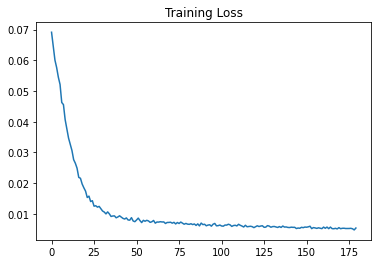

In [27]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

---
# Test the Trained Network

In this case, there are two ways to test the trained model: looking at how it classifies test data, and looking at how its reconstructions compare to original input images.

## Test Data
First, I'll test this model on previously unseen **test data** and evaluate its performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [29]:
def test(capsule_net, test_loader):
    '''Prints out test statistics for a given capsule net.
       param capsule_net: trained capsule network
       param test_loader: test dataloader
       return: returns last batch of test image data and corresponding reconstructions
       '''
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    
    test_loss = 0 # loss tracking

    labels = []
    predictions = []

    capsule_net.eval() # eval mode

    for batch_i, (images, target) in enumerate(test_loader):
        target = torch.eye(len(classes)).index_select(dim=0, index=target)

        batch_size = images.size(0)

        if TRAIN_ON_GPU:
            images, target = images.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        caps_output, reconstructions, y = capsule_net(images)
        # calculate the loss
        loss = criterion(caps_output, target, images, reconstructions)
        # update average test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target_shape.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())

    # avg test loss
    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss: {:.8f}\n'.format(avg_test_loss))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    # Total Test accuracy
    print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
    print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
    print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
    print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))
    
    # return last batch of capsule vectors, images, reconstructions
    return caps_output, images, reconstructions

In [30]:
# call test function and get reconstructed images
caps_output, images, reconstructions = test(capsule_net, test_loader)

Test Loss: 0.31899236

Test Accuracy of     0: 100% (23/23)
Test Accuracy of     1: 100% (16/16)
Test Accuracy of     2: 100% (17/17)
Test Accuracy of     3: 100% (16/16)
Test Accuracy of     4: 100% (19/19)
Test Accuracy of     5: 100% (16/16)
Test Accuracy of     6: 100% (13/13)
Test Accuracy of     7: 100% (20/20)
Test Accuracy of     8: 100% (16/16)
Test Accuracy of     9: 100% (12/12)
Test Accuracy of    10: 100% (18/18)
Test Accuracy of    11: 100% (14/14)
Test Accuracy of    12: 100% (19/19)
Test Accuracy of    13: 100% (10/10)
Test Accuracy of    14: 100% (18/18)
Test Accuracy of    15: 100% (13/13)
Test Accuracy of    16: 85% (12/14)
Test Accuracy of    17: 100% (19/19)
Test Accuracy of    18: 100% (13/13)
Test Accuracy of    19: 100% (14/14)
Test Accuracy of    20: 81% ( 9/11)
Test Accuracy of    21: 100% (13/13)
Test Accuracy of    22: 100% (18/18)
Test Accuracy of    23: 100% (11/11)
Test Accuracy of    24: 100% (16/16)
Test Accuracy of    25: 100% (25/25)
Test Accuracy of 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Display Reconstructions

Second, I'll display original images and their reconstructions to see how well the decoder trained.

In [31]:
def display_images(images, reconstructions):
    '''Plot one row of original MNIST images and another row (below) 
       of their reconstructions.'''
    # convert to numpy images
    images = images.data.cpu().numpy()
    reconstructions = reconstructions.view(-1, 1, 75, 75)
    reconstructions = reconstructions.data.cpu().numpy()
    
    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, reconstructions], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

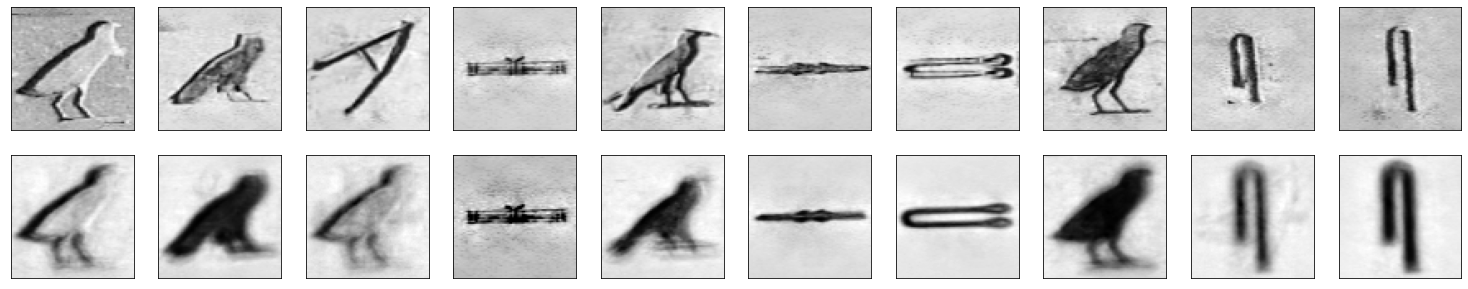

In [32]:
# display original and reconstructed images, in rows
display_images(images, reconstructions)